# Invasive Species Monitoring and the power of transfer learning

The goal of this notebook is to classify images of invasive plant species.

The data for this competition can be found [here](https://www.kaggle.com/c/invasive-species-monitoring).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. 
To get the data: <br>
`kaggle competitions download -c invasive-species-monitoring -p .` <br>

In [3]:
PATH = Path("/data2/yinterian/invasive-species-monitoring/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/invasive-species-monitoring/train_labels.csv'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train.7z'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/test.7z'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/model.pth'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/__MACOSX'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/mode_tmp.pth'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/test'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train_303_227'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/sample_submission.csv.zip'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/models'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train_labels.csv.zip')]

In [4]:
list((PATH/"train").iterdir())[:10] 

[PosixPath('/data2/yinterian/invasive-species-monitoring/train/2249.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/92.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/302.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/2031.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1903.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1605.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/352.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/654.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1261.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/388.jpg')]

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

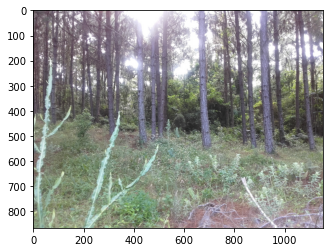

In [6]:
path = PATH/"train/2249.jpg"
im = read_image(path)
plt.imshow(im)

In [7]:
im = cv2.imread(str(path))
im.shape

(866, 1154, 3)

In [8]:
# let's look at the typical size of these images
path = PATH/"train"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]

In [9]:
np.unique(dims)

array([   3,  866, 1154])

Amazing! all images have the same size.

In [10]:
866/3.8, 1154/3.8

(227.89473684210526, 303.6842105263158)

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [11]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

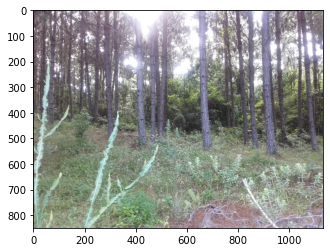

In [12]:
path = PATH/"train/2249.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

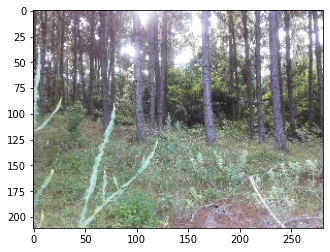

In [13]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (303, 227))
im2 = random_crop(im)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

1.7375537688098208


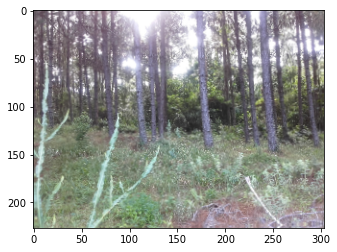

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

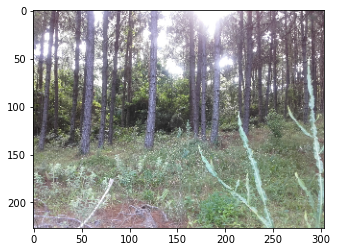

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [16]:
labels = pd.read_csv(PATH/"train_labels.csv")
labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [17]:
# how many classes
np.unique(labels.invasive.values)

array([0, 1])

In [18]:
# ration of 1 / total
labels.invasive.values.sum()/len(labels)

0.6309368191721133

In [19]:
np.random.seed(3)
mask = np.random.random(len(labels)) < 0.8
train_labels = labels[mask].copy()
valid_labels = labels[~mask].copy()

In [20]:
len(labels), len(train_labels), len(valid_labels) 

(2295, 1860, 435)

## Resizing data
Resizing the data before you do training will save you lots of time!

In [21]:
def resize_crop_image(path, sz=(303, 227)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

In [22]:
def resize_all_images(resize_path, org_path):
    files = [x for x in list(org_path.iterdir()) if x.suffix == ".jpg"]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [23]:
# just run the first time
#resize_all_images(PATH/"train_303_227", PATH/"train")

## Dataset

In [24]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [25]:
class InvasiveDataset(Dataset):
    def __init__(self, files_path, labels, transform=False):
        self.num_files = len(labels)
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        row = self.labels.iloc[index,:]
        y = row["invasive"]
        file_name = str(row["name"]) + ".jpg"
        path = self.files_path/file_name
        x = read_image(path)/255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), y[None]

In [26]:
train_ds = InvasiveDataset(PATH/"train_303_227", labels=train_labels, transform=True)
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)

In [27]:
len(train_ds), len(valid_ds)

(1860, 435)

In [28]:
x, y = train_ds[0]
x.shape,y

((3, 211, 281), array([0]))

In [29]:
x, y = valid_ds[0]
x.shape,y

((3, 211, 281), array([1]))

In [30]:
len(train_ds)

1860

In [31]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [32]:
x.shape,y

((3, 211, 281), array([0]))

## Toy model

In [33]:
class ToyNet(nn.Module):
    def __init__(self):
        super(ToyNet, self).__init__()
        self.conv1= nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, 1) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [34]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [35]:
x, y = next(iter(train_dl))

In [36]:
x.shape

torch.Size([5, 3, 211, 281])

In [37]:
model = ToyNet()
y_hat = model(x.float())

In [38]:
conv1= nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
av_ppol = nn.AdaptiveAvgPool2d((1,1))
fc = nn.Linear(128, 1)

In [39]:
x.shape

torch.Size([5, 3, 211, 281])

In [40]:
x1 = conv1(x.float())
x1.shape

torch.Size([5, 32, 211, 281])

In [41]:
x2 = F.relu(x1)
x2.shape

torch.Size([5, 32, 211, 281])

In [42]:
x3 = F.max_pool2d(x2, kernel_size=2, stride=2)
x3.shape

torch.Size([5, 32, 105, 140])

In [43]:
x4 = conv2(x3)
x5 = F.relu(x4)
x6 = F.max_pool2d(x5, kernel_size=2, stride=2)
x5.shape, x6.shape

(torch.Size([5, 64, 105, 140]), torch.Size([5, 64, 52, 70]))

In [44]:
x7 = conv3(x6)
x8 = F.relu(x7)
x9 = F.max_pool2d(x8, kernel_size=2, stride=2)
x9.shape

torch.Size([5, 128, 26, 35])

In [45]:
x10 = av_ppol(x9)
x10.shape

torch.Size([5, 128, 1, 1])

In [46]:
x11 = x10.reshape(x10.size(0), -1)
x11.shape

torch.Size([5, 128])

In [47]:
x12 = fc(x11)
x12.shape

torch.Size([5, 1])

In [48]:
F.binary_cross_entropy_with_logits(x12, y.float())

tensor(0.7237, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### Trainning toy model

In [49]:
def train_one_epoch(model, optimizer, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

In [50]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            pred = (out > 0.0).long()
            correct += pred.eq(y.data).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total

In [51]:
def train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5):
    for i in range(epochs):
        train_loss = train_one_epoch(model, optimizer, train_dl)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

In [52]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [53]:
model = ToyNet().cuda()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [54]:
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5)

train_loss 1.431 val_loss 0.667 val_acc 0.632
train_loss 0.664 val_loss 0.660 val_acc 0.632
train_loss 0.659 val_loss 0.658 val_acc 0.632
train_loss 0.659 val_loss 0.658 val_acc 0.632
train_loss 0.659 val_loss 0.658 val_acc 0.632


# Model

In [126]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [127]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=512, out_features=1000, bias=True)]

In [128]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [129]:
model = Net().cuda()

In [130]:
x, y = next(iter(train_dl))

In [131]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([5, 3, 211, 281])

In [132]:
x_features = model.features1(x)
x_features.shape

torch.Size([5, 128, 27, 36])

In [133]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([5, 512, 7, 9])

In [134]:
x_features2 = F.relu(x_features2)

In [135]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([5, 512, 1, 1])

In [136]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([5, 512])

In [137]:
y_hat = model(x)
y_hat.shape

torch.Size([5, 1])

In [138]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y)

tensor(0.8128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [139]:
y.shape

torch.Size([5, 1])

## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

In [48]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def binary_loss(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
binary_loss(1, 0.5)

0.6931471805599453

In [49]:
# example
y = np.array([1, 1, 0])
y_logit = np.array([10, 1, -1])
sigmoid(y_logit)

array([0.9999546 , 0.73105858, 0.26894142])

In [50]:
l = [binary_loss(y1, p1) for y1,p1 in zip(y, sigmoid(y_logit))]
l

[4.539889921682063e-05, 0.3132616875182228, 0.3132616875182228]

In [51]:
np.mean(l)

0.20885625797855414

In [52]:
F.binary_cross_entropy_with_logits(torch.FloatTensor(y_logit), torch.FloatTensor(y))

tensor(0.2089)

In [53]:
# here we use sigmoid
F.binary_cross_entropy(torch.sigmoid(torch.FloatTensor(y_logit)), torch.FloatTensor(y))

tensor(0.2089)

### Training a pretrained model

In [142]:
def create_optimizer(model, lr0):
    """ Creates an optimizer with different learning rates for groups of layers"""
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

In [143]:
model = Net().cuda()
optimizer = create_optimizer(model, 0.001)
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5)

train_loss 0.389 val_loss 0.166 val_acc 0.956
train_loss 0.275 val_loss 0.115 val_acc 0.970
train_loss 0.207 val_loss 0.185 val_acc 0.933
train_loss 0.205 val_loss 0.100 val_acc 0.966
train_loss 0.205 val_loss 0.157 val_acc 0.945


In [144]:
model = Net().cuda()
optimizer = create_optimizer(model, 0.001)
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 10)

train_loss 0.380 val_loss 0.127 val_acc 0.956
train_loss 0.249 val_loss 0.170 val_acc 0.933
train_loss 0.214 val_loss 0.116 val_acc 0.949
train_loss 0.209 val_loss 0.149 val_acc 0.947
train_loss 0.165 val_loss 1.185 val_acc 0.775
train_loss 0.158 val_loss 0.446 val_acc 0.802
train_loss 0.125 val_loss 0.098 val_acc 0.970
train_loss 0.169 val_loss 0.073 val_acc 0.979
train_loss 0.116 val_loss 0.074 val_acc 0.975
train_loss 0.130 val_loss 0.071 val_acc 0.979


## Learning rate finder

From this paper https://arxiv.org/pdf/1506.01186.pdf. This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from 1e-5 to 0.012.

In [140]:
def update_optimizer(optimizer, group_lrs):
    """Updates laerning rates"""
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [141]:
model = Net().cuda()
optimizer = create_optimizer(model, 0.001)
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5)

train_loss 0.371 val_loss 0.160 val_acc 0.938
train_loss 0.259 val_loss 0.153 val_acc 0.961
train_loss 0.222 val_loss 0.093 val_acc 0.968
train_loss 0.224 val_loss 0.161 val_acc 0.936
train_loss 0.179 val_loss 0.137 val_acc 0.954


In [55]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))


def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses    

In [139]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1)

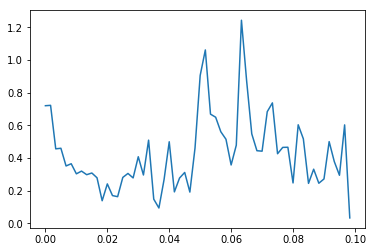

In [142]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [56]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

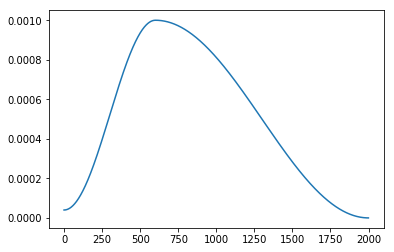

In [57]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [58]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [59]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_resnet34_{1:.0f}.pth".format(PATH, 100*val_acc)
            save_model(model, path)
            print(path)

In [60]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            pred = (out > 0.0).long()
            correct += pred.eq(y.data).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total

## Training with triangular rates

In [61]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [158]:
model = Net().cuda()

In [153]:
val_metrics(model, valid_dl)

(12.934475870242064, 0.632183908045977)

In [175]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 5)

train_loss 0.249 val_loss 60.933 val_acc 0.368
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_37.pth
train_loss 0.224 val_loss 0.386 val_acc 0.903
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_90.pth
train_loss 0.191 val_loss 0.934 val_acc 0.743
train_loss 0.179 val_loss 0.171 val_acc 0.940
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.123 val_loss 0.125 val_acc 0.956
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_96.pth


In [178]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 8)

train_loss 0.222 val_loss 1.503 val_acc 0.710
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_71.pth
train_loss 0.177 val_loss 2.221 val_acc 0.172
train_loss 0.231 val_loss 0.237 val_acc 0.913
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_91.pth
train_loss 0.208 val_loss 0.459 val_acc 0.805
train_loss 0.126 val_loss 0.108 val_acc 0.956
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_96.pth
train_loss 0.170 val_loss 1.667 val_acc 0.632
train_loss 0.134 val_loss 0.139 val_acc 0.940
train_loss 0.109 val_loss 0.142 val_acc 0.938


In [62]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 10)

train_loss 0.219 val_loss 19.224 val_acc 0.524
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_52.pth
train_loss 0.233 val_loss 1.747 val_acc 0.782
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_78.pth
train_loss 0.267 val_loss 0.234 val_acc 0.917
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_92.pth
train_loss 0.179 val_loss 1.380 val_acc 0.724
train_loss 0.142 val_loss 0.093 val_acc 0.954
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_95.pth
train_loss 0.123 val_loss 0.091 val_acc 0.966
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_97.pth
train_loss 0.102 val_loss 0.092 val_acc 0.970
train_loss 0.111 val_loss 0.076 val_acc 0.970
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_97.pth
train_loss 0.056 val_loss 0.050 val_acc 0.989
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_99.pth
train_loss 0.054 val_loss 0.049 val_acc 0.982
/data2/yinterian/inva

In [180]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 15)

train_loss 0.213 val_loss 2.395 val_acc 0.763
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_76.pth
train_loss 0.149 val_loss 0.704 val_acc 0.690
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_69.pth
train_loss 0.246 val_loss 0.353 val_acc 0.887
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_89.pth
train_loss 0.195 val_loss 0.222 val_acc 0.936
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.146 val_loss 0.176 val_acc 0.945
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.125 val_loss 0.549 val_acc 0.825
train_loss 0.180 val_loss 0.468 val_acc 0.899
train_loss 0.203 val_loss 0.268 val_acc 0.901
train_loss 0.147 val_loss 0.188 val_acc 0.931
train_loss 0.108 val_loss 0.107 val_acc 0.952
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_95.pth
train_loss 0.097 val_loss 0.103 val_acc 0.959
/data2/yinterian/invasive-species-monitoring/model

## Load a model

In [21]:
PATH

PosixPath('/data2/yinterian/invasive-species-monitoring')

In [26]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [63]:
# load model
model = Net().cuda()
p = PATH/"models/model_resnet34_99.pth"
load_model(model, p)

In [64]:
val_metrics(model, valid_dl)

(0.049681160633248844, 0.9885057471264368)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions. This usually helps but here our accuracy is too high.

In [65]:
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)
valid_ds_trs = InvasiveDataset(PATH/"train_303_227", labels=valid_labels, transform=True)

In [66]:
# note that I am not shuffling the data loaders
batch_size = 32
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
valid_dl_trs = DataLoader(valid_ds_trs, batch_size=batch_size)

In [67]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        pred = (out > 0.0).long()
        preds.append(pred.cpu().numpy())
        ys.append(y.numpy())
    return np.vstack(preds), np.vstack(ys)

In [68]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [69]:
TTAaccuracy(model, valid_dl, valid_dl_trs)

0.9839080459770115